# Running and Timing Programs

In this notebook, we'll learn how to write programs that can launch other programs and time how long it takes to do things (you'll often be combining these skills to time how long it takes to run a program).

Both these skills are covered in much more detail in an optional reading, Chapter 17 of Automate the Boring Stuff: https://automatetheboringstuff.com/2e/chapter17/.  If you decide to read that, we recommend skipping the middle sections, "Multithreading" through "Project: Multithreaded XKCD Downloader"

## Running Programs

### Example 1: Running `pwd`

Remember that running the `pwd` program in a shell tells you what directly you're currently in.  Let's write some Python code to run the `pwd` program automatically and capture the output.  We'll do this with the `check_output` function in the `subprocess` module (https://docs.python.org/2/library/subprocess.html#subprocess.check_output) -- let's import that.

In [1]:
from subprocess import check_output

In the simplest form, we can run pass a program name (as a string) to the function, which will capture and return the output:

In [2]:
output = check_output("pwd")
output

b'/home/trh/lec3\n'

What type is that output?  It looks like a string, but with a "b" in front.  Hmmmm....

In [3]:
type(output)

bytes

The `bytes` type in Python is a sequence, like a string.  The difference is that `bytes` may contain letters (as in this case), or other types.  If we know the encoding of a bytes sequence, we can convert to a string as follows:

In [4]:
str_output = str(output, encoding="utf-8")
str_output

'/home/trh/lec3\n'

In [5]:
type(str_output)

str

### Example 2: Checking Versions

What version of git do we have on this computer?  From the command line, we could run `git --version` to find out.  But let's do that in code.  This is a little trickier because we have both a program name, `git`, and an argument, `--version`.  The `checkout_output` function supports two ways of running programs with arguments.

Way 1: pass `shell=True`

In [6]:
check_output("git --version", shell=True)

b'git version 2.17.1\n'

Or (preferred), we can pass the program and arguments in one list:

In [7]:
check_output(["git", "--version"])

b'git version 2.17.1\n'

Let's actually do the string manipulation work to isolate the version:

In [8]:
output = str(check_output(["git", "--version"]), encoding="utf-8")
output

'git version 2.17.1\n'

In [9]:
parts = output.strip().split()
parts

['git', 'version', '2.17.1']

In [10]:
version = parts[-1]
version

'2.17.1'

If we needed to have a specific version, we might use the above to have an assert like this:

```
assert version == `2.17.1`
```

What if the program isn't installed, or we pass it some arguments that cause it to crash, as in the following example?  We'll want to have catch some exceptions in these scenarios:

In [11]:
import subprocess

try:
    output = str(check_output(["git", "--oops"]), encoding="utf-8")
except FileNotFoundError:
    print("program not installed?")
except subprocess.CalledProcessError as e:
    print("program crashed")
    # if there were any output before it crashed, we could look at it
    # with this:
    print("OUTPUT:", e.output)

program crashed
OUTPUT: b''


In [12]:
check_output(["lsb_release", "-a"], stderr=subprocess.STDOUT)

b'No LSB modules are available.\nDistributor ID:\tUbuntu\nDescription:\tUbuntu 18.04.3 LTS\nRelease:\t18.04\nCodename:\tbionic\n'

### Example 3: Making Animations

A common situation is that there will be some program that does something useful that we can't directly do in Python, and we'll want to write Python code to run these external programs to make use of their features.

For example, the `ffmpeg` program can make an animated video by glueing together a bunch of `.png` image files in sequence.  There are ways to make animations directly in Python, but for now let's see how we can execute `ffmpeg` with `check_output` to make a video.

First, you should install the `ffmpeg` program on Ubuntu so we can use it -- run the following in the shell:

```
sudo apt install ffmpeg
```

Now, let's write some code to make a series of plots with a red dot in different positions, and save those plots as `0.png`, `1.png`, etc.  The idea is that these images are similar enough that if you flipped through them, it would look like a rough video.

In [13]:
import os
import matplotlib
from matplotlib import pyplot as plt

In [14]:
%matplotlib inline

In [15]:
matplotlib.rcParams["font.size"] = 16

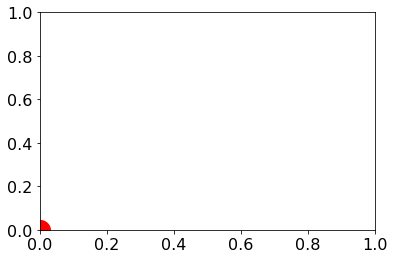

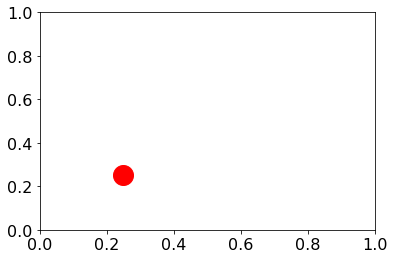

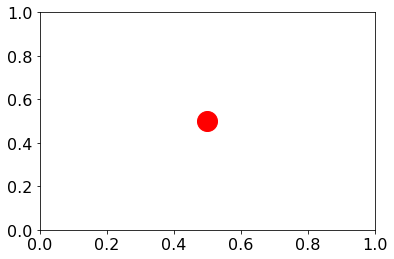

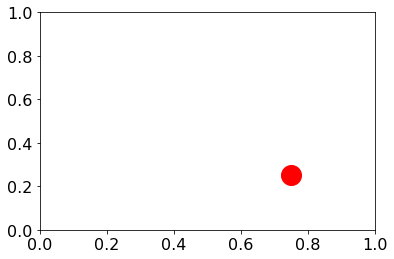

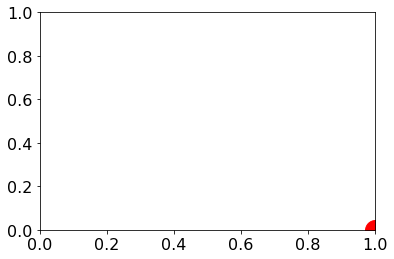

In [16]:
def plot_circle(filename, x, y):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.plot(x, y, 'ro', markersize=20)
    fig.savefig(os.path.join("img", filename))

if not os.path.exists("img"):
    os.mkdir("img")

plot_circle("0.png", x=0, y=0)
plot_circle("1.png", x=0.25, y=0.25)
plot_circle("2.png", x=0.5, y=0.5)
plot_circle("3.png", x=0.75, y=0.25)
plot_circle("4.png", x=1, y=0)

Let's check that we created the png files in the `img` directory:

In [17]:
os.listdir("img")

['0.png', '1.png', '4.png', '2.png', '3.png']

Let's also check that they look right.  In the `IPython.display` module, there are `Image(...)` and `HTML(...)` functions that are useful for loading pictures and HTML directly into our notebook.  Let's use the first function to check that our `0.png` file looks right.

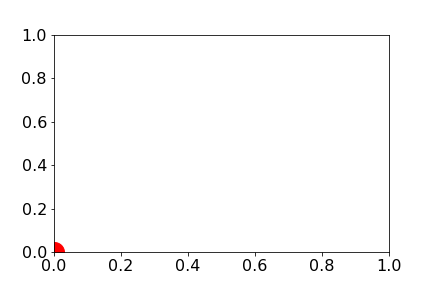

In [18]:
from IPython.display import Image, HTML
Image(filename='img/0.png')

Great!  Now, from the command line, try running this command, inside the same directory where this notebook is running:

```
'ffmpeg -y -framerate 5 -i img/%d.png out.mp4
```

If it succeeds, there should be an out.mp4 file generated.  Try downloading it to your computer via the Jupyter interface (don't try to open it directly from Jupyter) and open it on your laptop.  Cool, huh?

Now let's try running that same command with `check_output`.  We'll need to break up all the arguments into different entries in a list:

In [19]:
check_output(['ffmpeg', '-y', '-framerate', '5', '-i', 'img/%d.png', 'out.mp4'])

b''

There was no output, which is fine.  But it should have created an `out.mp4` file, as before.  You can embed `.mp4` video files in websites with the `<video>` tag.  This is great because we can inject HTML using the `HTML(...)` function from earlier:

In [20]:
HTML("This is <b>bold</b> text.")

The natural thing to do is to inject some HTML to embed the `out.mp4` animation we just created:

In [21]:
HTML("""
<video width="320" height="240" controls>
  <source src="out.mp4" type="video/mp4">
</video>
""")

## Measuring Time

The easiest way to measure how long something takes is to check the time before and after we do it.  We can check with the `time` function inside the `time` module.  This function returns the number of seconds elapsed since Jan 1, 1970:

In [22]:
import time
now = time.time()
now

1580012140.156789

In [23]:
minutes = now / 60
hours = minutes / 60
days = hours / 24
years = days / 365
years # should be about number of years since 1970 -- is it?

50.10185629619448

Let's use this to time how long a print call takes:

In [24]:
before = time.time()
print("I'm printing something")
after = time.time()
print("It took", (after-before), "seconds to print")

I'm printing something
It took 0.0007674694061279297 seconds to print


A slightly cleaner version of the same that computers milliseconds (1ms is 1/1000 seconds):

In [25]:
t0 = time.time()
print("I'm printing something")
t1 = time.time()
ms = (t1-t0) * 1000
print("It took", ms, "ms to print")

I'm printing something
It took 1.5339851379394531 ms to print


How long does it take to append something to the end of a list?

In [26]:
L = []
t0 = time.time()
L.append("test")
t1 = time.time()
us = (t1-t0) * 1e6 # microseconds (there are 1 second has 1000000 microseconds)
print("microseconds:", us)

microseconds: 46.49162292480469


The problem with the above measurement is that it is it varies significantly each time you try it, and we can easily end up measuring something other than append time.  For example, what if calling `time.time()` is much slower than calling `L.append("test")`?  It is better to perform an operation many times between checking the start+stop times and then divide to get the average cost of the operation:

In [27]:
L = []
append_count = 1000000 # do 1 million appends
t0 = time.time()
for i in range(append_count):
    L.append("test")
t1 = time.time()
us = (t1-t0) / append_count * 1e6 # microseconds (there are 1 second has 1000000 microseconds)
print("microseconds:", us)

microseconds: 0.11628866195678711


### Example 1: the `in` operator

The `in` operator can be used to check whether a value is in a list or a set, but it's much faster on a set.  If your code needs to perform the `in` operation a lot, this is a good reason to use a set rather than a list.  Let's review how `in` works on each:

In [28]:
L = ["A", "B", "C"]
S = {"A", "B", "C"}

In [29]:
"A" in L, "D" in L, "A" in S, "D" in S

(True, False, True, False)

Let's see how fast `in` is if we are checking over 1 million numbers in a list or a set.

In [30]:
seq_size = 1000000
L = list(range(seq_size))
S = set(range(seq_size))

# return average microseconds to perform lookup
def time_lookup(data, search):
    trials = 1000
    t0 = time.time()
    for i in range(trials):
        found = search in data
    t1 = time.time()
    return (t1-t0)*1e6/trials

time_lookup(L, 0), time_lookup(S, 0)

(0.03838539123535156, 0.03647804260253906)

Ok, looks like looking up `0` (the first number) is about equally fast in either data structure.

What if we lookup a number that's not stored?

In [31]:
time_lookup(L, -1), time_lookup(S, -1)

(10005.323648452759, 0.05078315734863281)

Woah, now the list is >10K times slower!  What if we lookup the last item in the list?

In [32]:
time_lookup(L, 999999), time_lookup(S, 999999)

(11370.5153465271, 0.06365776062011719)

The set is fast again, but the list is still really slow (about as slow as looking up something that doesn't exist).  What if we lookup a number in the middle?

In [33]:
time_lookup(L, 500000), time_lookup(S, 500000)

(5665.204048156738, 0.05984306335449219)

Well, checking for something in the middle of a list is about twice as fast as checking for the last item.  Can you guess why?

It turns out that while sets are designed around making `in` fast, running `in` on a list amounts to looping over ever item, much like a call to the following function.

In [34]:
def is_in(L, search):
    for item in L:
        if search == L: # if this is True early in the list, the search is fast
            return True
    return False

How does the list size factor in when we perform an `in` and we don't find anything?  Let's do an experiment to find out.

In [35]:
from pandas import Series

times = Series()

for size in [1000, 2000, 5000, 10000]:
    L = list(range(size))
    microseconds = time_lookup(L, -1)
    times.loc[size] = microseconds
times

1000      9.924889
2000     19.252300
5000     48.464060
10000    96.690893
dtype: float64

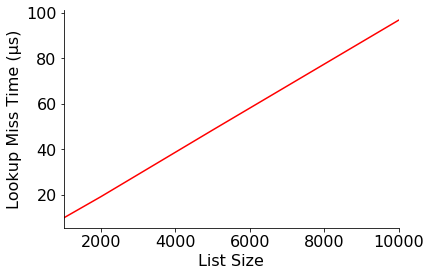

In [36]:
ax = times.plot.line(color="r")

# following makes plot look better (only necessary if we plan to share it with others)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel("List Size")
ax.set_ylabel("Lookup Miss Time (μs)")
None

Looking at the above, we would say that the `in` operator scales *linearly*.  In otherwords, doubling the list size doubles the time it takes to perform the operation.

### Example 2: Ratio Search

Not all functions we'll encounter will scale linearly.  For example, consider this one, which checks whether the ratio of any two numbers in a list matches the ration we're searching for:

In [37]:
def ratio_search(L, ratio):
    for numerator in L:
        for denominator in L:
            if numerator / denominator == ratio:
                return True
    return False

ratio_search([1, 2, 3, 4], 0.75)

True

In [38]:
ratio_search([1, 2, 3, 4], 0.2)

False

Let's see how it scales when we search for a ratio we know we won't find.

In [39]:
import random, string

times = Series()

for i in range(6):
    size = i * 1000
    L = list(range(1, size+1)) # don't include 0, because we need to divide

    t0 = time.time()
    found = ratio_search(L, -1)
    t1 = time.time()

    times.loc[size] = t1-t0
times

0       0.000002
1000    0.056617
2000    0.222575
3000    0.508784
4000    0.892418
5000    1.397332
dtype: float64

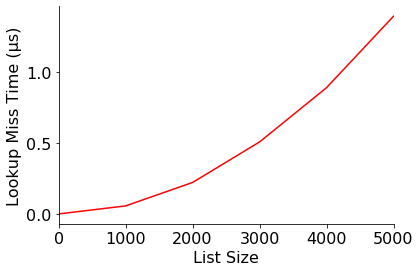

In [40]:
ax = times.plot.line(color="r")

# following makes plot look better (only necessary if we plan to share it with others)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel("List Size")
ax.set_ylabel("Lookup Miss Time (μs)")
None

The above is an example of quadratic scaling: doubling the list size quadruples the time it takes to run!

# Conclusion

In this notebook, we've learned how to automatically run programs and time code.  Together, these skills provide the empirical basis for exploring performance and scalability.  Soon, we'll be learning a bit of theory (complexity analysis) and notation (big-O) for thinking about what happens to performance as we add more data.